'''

==========================================

Milestone 3

Nama    : Muhammad Raihan Alfain Yonanda

Batch   : CODA-012-RMT

Program ini dibuat untuk melakukan pre automasi data penjualan BMW dengan melakukan ETL dan Validasi data.

Link PPT: https://docs.google.com/presentation/d/1yeFqg09UgUNceyakMxdz4gDZ7Xsxz8soddZpYvLdHCw/edit?usp=sharing

==========================================


'''

# 0. Setup & Library

### 0.1 Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import great_expectations as gx
from great_expectations.core.expectation_suite import ExpectationSuite

### 0.2 Path

In [2]:
path = "data/BMW sales data (2010-2024).csv"

In [3]:
import os
print("CWD:", os.getcwd())
print("Isi folder root:", os.listdir())

CWD: d:\HACKTIV8\Phase 2\airflow-with-spark
Isi folder root: ['.env', '.git', '.gitignore', 'airflow.yaml', 'dags', 'data', 'Dockerfile', 'gx_project', 'logs', 'P2M3_Raihan_Alfain.ipynb', 'README.md', 'requirements.txt', 'scripts', 'test']


# 1. Load Data

### 1.1 Load full data

In [4]:
df = pd.read_csv(path)
df

,Model,Year,Region,Color,Fuel_Type,Transmission,Engine_Size_L,Mileage_KM,Price_USD,Sales_Volume,Sales_Classification
0,5 Series,2016,Asia,Red,Petrol,Manual,3.5,151748,98740,8300,High
1,i8,2013,North America,Red,Hybrid,Automatic,1.6,121671,79219,3428,Low
2,5 Series,2022,North America,Blue,Petrol,Automatic,4.5,10991,113265,6994,Low
3,X3,2024,Middle East,Blue,Petrol,Automatic,1.7,27255,60971,4047,Low
4,7 Series,2020,South America,Black,Diesel,Manual,2.1,122131,49898,3080,Low
...,...,...,...,...,...,...,...,...,...,...,...
49995,i3,2014,Asia,Red,Hybrid,Manual,4.6,151030,42932,8182,High
49996,i3,2023,Middle East,Silver,Electric,Manual,4.2,147396,48714,9816,High
49997,5 Series,2010,Middle East,Red,Petrol,Automatic,4.5,174939,46126,8280,High
49998,i3,2020,Asia,White,Electric,Automatic,3.8,3379,58566,9486,High


### 1.2 Cek ukuran data

In [5]:
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())

Shape: (50000, 11)
Columns: ['Model', 'Year', 'Region', 'Color', 'Fuel_Type', 'Transmission', 'Engine_Size_L', 'Mileage_KM', 'Price_USD', 'Sales_Volume', 'Sales_Classification']


# 3. Cek Tipe Data & Struktur

### 2.1 Info & dtype

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Model                 50000 non-null  object 
 1   Year                  50000 non-null  int64  
 2   Region                50000 non-null  object 
 3   Color                 50000 non-null  object 
 4   Fuel_Type             50000 non-null  object 
 5   Transmission          50000 non-null  object 
 6   Engine_Size_L         50000 non-null  float64
 7   Mileage_KM            50000 non-null  int64  
 8   Price_USD             50000 non-null  int64  
 9   Sales_Volume          50000 non-null  int64  
 10  Sales_Classification  50000 non-null  object 
dtypes: float64(1), int64(4), object(6)
memory usage: 4.2+ MB


### 2.2 Tabel ringkas kolom & dtype

In [7]:
pd.DataFrame({
    "column": df.columns,
    "dtype": [df[c].dtype for c in df.columns],
    "n_unique": [df[c].nunique(dropna=False) for c in df.columns]
}).sort_values("n_unique", ascending=True)


,column,dtype,n_unique
5,Transmission,object,2
10,Sales_Classification,object,2
4,Fuel_Type,object,4
3,Color,object,6
2,Region,object,6
0,Model,object,11
1,Year,int64,15
6,Engine_Size_L,float64,36
9,Sales_Volume,int64,9845
8,Price_USD,int64,38246


### 2.3 Contoh cek nilai unik untuk kolom kategorikal

In [8]:
cat_cols = ["Region", "Fuel_Type", "Transmission", "Sales_Classification", "Model", "Color"]

for c in cat_cols:
    print(f"\n=== {c} (top 10) ===")
    display(df[c].value_counts(dropna=False).head(10))


=== Region (top 10) ===


Region
Asia             8454
Middle East      8373
North America    8335
Europe           8334
Africa           8253
South America    8251
Name: count, dtype: int64


=== Fuel_Type (top 10) ===


Fuel_Type
Hybrid      12716
Petrol      12550
Electric    12471
Diesel      12263
Name: count, dtype: int64


=== Transmission (top 10) ===


Transmission
Manual       25154
Automatic    24846
Name: count, dtype: int64


=== Sales_Classification (top 10) ===


Sales_Classification
Low     34754
High    15246
Name: count, dtype: int64


=== Model (top 10) ===


Model
7 Series    4666
i3          4618
i8          4606
3 Series    4595
5 Series    4592
X1          4570
X3          4497
X5          4487
M5          4478
X6          4478
Name: count, dtype: int64


=== Color (top 10) ===


Color
Red       8463
Silver    8350
Grey      8348
White     8304
Black     8273
Blue      8262
Name: count, dtype: int64

# 3. Missing Values & Duplicate

### 3.1 Missing values per kolom

In [9]:
missing = df.isna().sum().sort_values(ascending=False)
missing


Model                   0
Year                    0
Region                  0
Color                   0
Fuel_Type               0
Transmission            0
Engine_Size_L           0
Mileage_KM              0
Price_USD               0
Sales_Volume            0
Sales_Classification    0
dtype: int64

### 3.2 Persentase missing

In [10]:
(missing / len(df) * 100).round(2)

Model                   0.0
Year                    0.0
Region                  0.0
Color                   0.0
Fuel_Type               0.0
Transmission            0.0
Engine_Size_L           0.0
Mileage_KM              0.0
Price_USD               0.0
Sales_Volume            0.0
Sales_Classification    0.0
dtype: float64

### 3.3 Duplicate rows (full row)

In [11]:
dup_count = df.duplicated().sum()
print("Duplicate rows:", dup_count)


Duplicate rows: 0


# 4. Ringkasan Statistik (Numerik & Kategorikal)
Tujuan: Lihat sebaran angka dan anomali (min/max), serta meringkas kategorikal.

### 4.1 Statistik numerik

In [12]:
num_cols = ["Year", "Engine_Size_L", "Mileage_KM", "Price_USD", "Sales_Volume"]
df[num_cols].describe()


,Year,Engine_Size_L,Mileage_KM,Price_USD,Sales_Volume
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,2017.015700,3.247180,100307.203140,75034.600900,5067.514680
std,4.324459,1.009078,57941.509344,25998.248882,2856.767125
min,2010.000000,1.500000,3.000000,30000.000000,100.000000
25%,2013.000000,2.400000,50178.000000,52434.750000,2588.000000
50%,2017.000000,3.200000,100388.500000,75011.500000,5087.000000
75%,2021.000000,4.100000,150630.250000,97628.250000,7537.250000
max,2024.000000,5.000000,199996.000000,119998.000000,9999.000000


### 4.2 Statistik kategorikal

In [13]:
df.describe(include="object")

,Model,Region,Color,Fuel_Type,Transmission,Sales_Classification
count,50000,50000,50000,50000,50000,50000
unique,11,6,6,4,2,2
top,7 Series,Asia,Red,Hybrid,Manual,Low
freq,4666,8454,8463,12716,25154,34754


### 4.3 Cek nilai minimum/maksimum cepat (untuk aturan filter)

In [14]:
for c in num_cols:
    print(c, "min=", df[c].min(), "max=", df[c].max())

Year min= 2010 max= 2024
Engine_Size_L min= 1.5 max= 5.0
Mileage_KM min= 3 max= 199996
Price_USD min= 30000 max= 119998
Sales_Volume min= 100 max= 9999


# 5. Distribusi Sederhana (Plot)
Tujuan: Cek distribusi / potensi outlier secara visual.

### 5.1 Histogram numerik

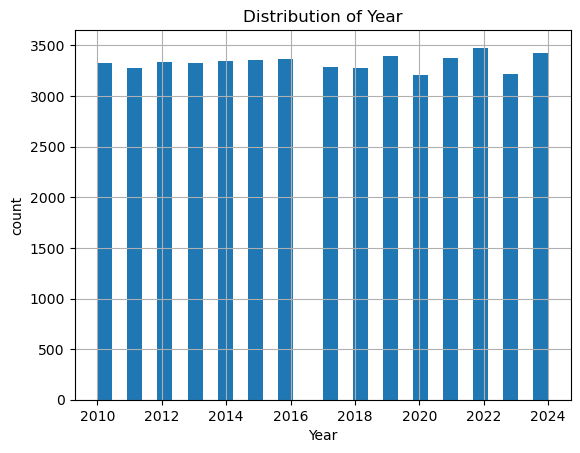

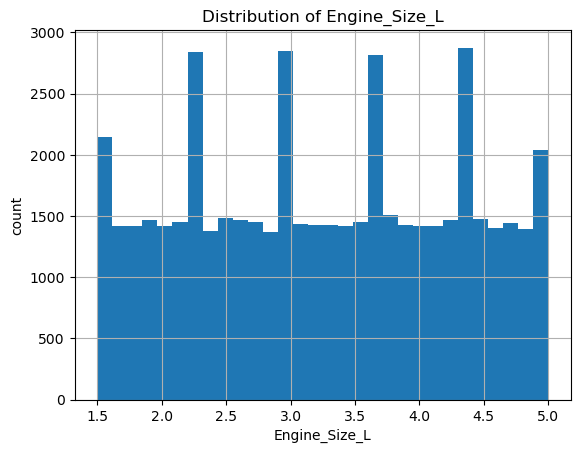

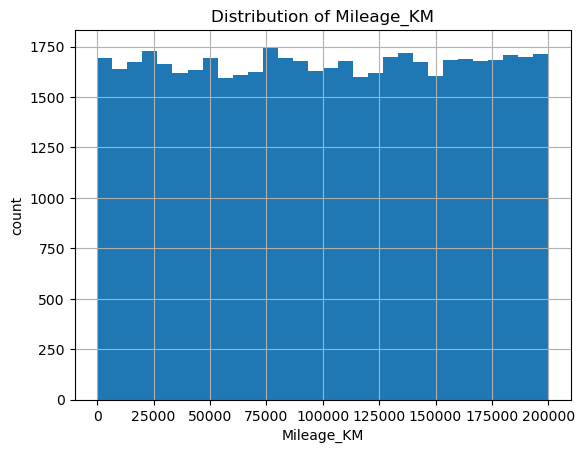

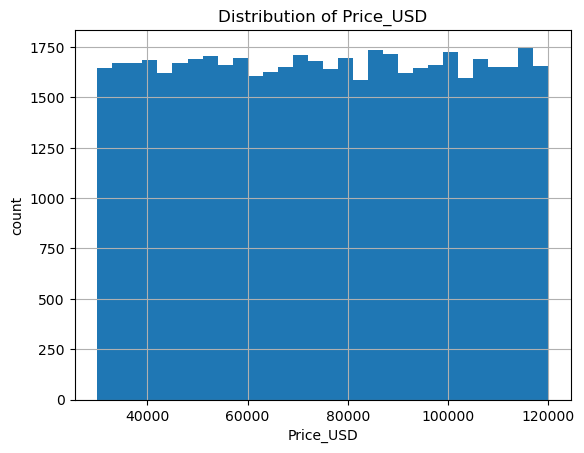

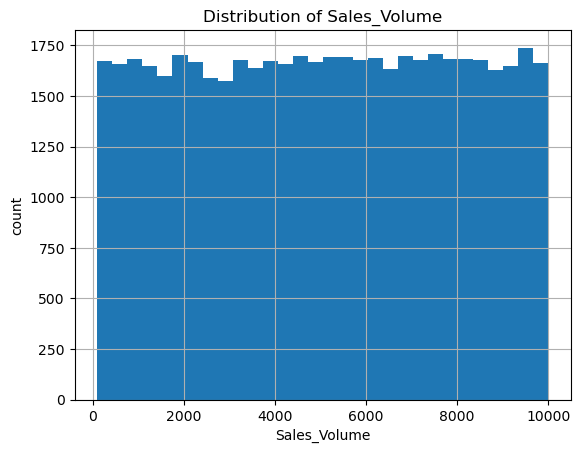

In [15]:
for c in num_cols:
    plt.figure()
    df[c].hist(bins=30)
    plt.title(f"Distribution of {c}")
    plt.xlabel(c)
    plt.ylabel("count")
    plt.show()

### 5.2 Bar chart kategorikal (top categories)

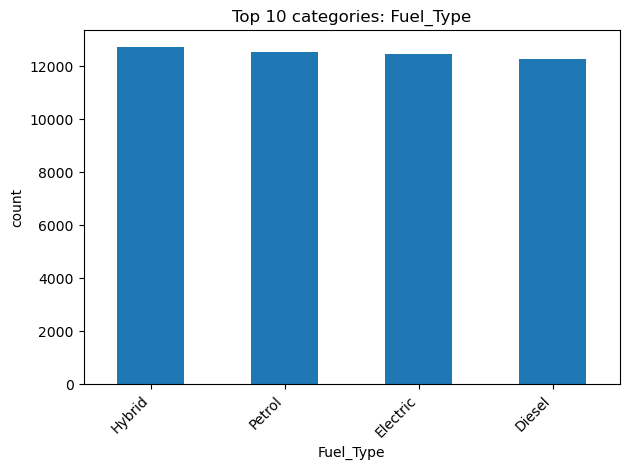

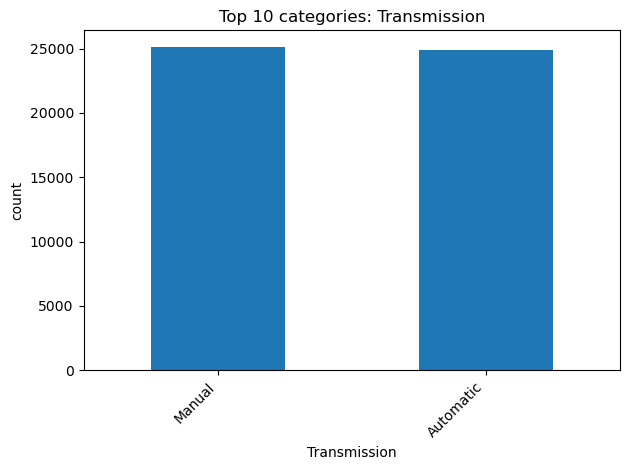

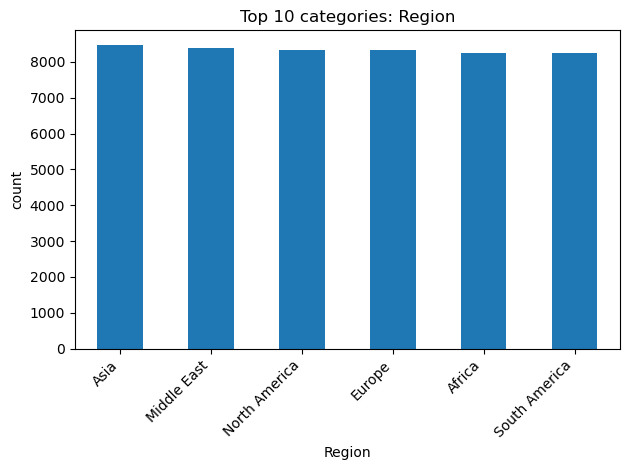

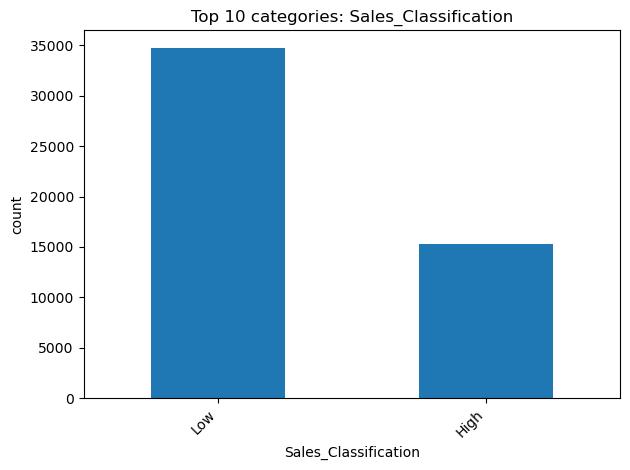

In [16]:
top_k = 10
for c in ["Fuel_Type", "Transmission", "Region", "Sales_Classification"]:
    plt.figure()
    df[c].value_counts().head(top_k).plot(kind="bar")
    plt.title(f"Top {top_k} categories: {c}")
    plt.xlabel(c)
    plt.ylabel("count")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()


# 6. Cek Konsistensi Format String (Trim/Whitespace)
Tujuan: Deteksi apakah ada spasi berlebih yang nanti perlu trim() di PySpark.

In [17]:
str_cols = ["Model", "Region", "Color", "Fuel_Type", "Transmission", "Sales_Classification"]

def has_extra_spaces(series: pd.Series) -> int:
    s = series.dropna().astype(str)
    return int((s != s.str.strip()).sum())

for c in str_cols:
    print(c, "rows with extra leading/trailing spaces:", has_extra_spaces(df[c]))

Model rows with extra leading/trailing spaces: 0
Region rows with extra leading/trailing spaces: 0
Color rows with extra leading/trailing spaces: 0
Fuel_Type rows with extra leading/trailing spaces: 0
Transmission rows with extra leading/trailing spaces: 0
Sales_Classification rows with extra leading/trailing spaces: 0


# 7. Kesimpulan EDA: Rencana Data Cleaning & Processing
Tujuan: menyusun langkah cleaning & processing yang akan diimplementasikan pada transform.py menggunakan PySpark.

### Casting tipe data (PySpark)

Year → integer

Engine_Size_L → double/float

Mileage_KM, Price_USD, Sales_Volume → integer

### String cleaning

trim() untuk kolom string: Model, Region, Color, Fuel_Type, Transmission, Sales_Classification

### Filtering aturan dasar

2010 <= Year <= 2024

Engine_Size_L > 0 dan < 10 (atau sesuaikan dengan max dari EDA)

Mileage_KM >= 0, Price_USD > 0, Sales_Volume >= 0

### Buat kolom unik untuk pipeline

Buat Record_ID dari gabungan kolom (untuk unique key & dedup)

### Dedup

dropDuplicates(["Record_ID"]) supaya rerun pipeline aman (idempotent)

# 8. Setup Great Expectations (7 expectations)

### 8.1 Setup

In [18]:
import great_expectations as gx
print("GE version:", gx.__version__)

GE version: 1.10.0


In [19]:
# siapkan dataframe untuk validasi
df_for_ge = df.copy()
df_for_ge["Record_ID"] = df_for_ge.astype(str).agg("|".join, axis=1)

In [21]:
# ambil context
context = gx.get_context(context_root_dir=r"D:\HACKTIV8\Phase 2\airflow-with-spark\gx_project")
print(type(context))

<class 'great_expectations.data_context.data_context.file_data_context.FileDataContext'>


In [22]:
# buat pandas datasource (idempotent)
datasource = context.data_sources.add_or_update_pandas(name="pandas_ds")

In [23]:
# buat asset (idempotent)
asset_name = "bmw_sales_asset"

try:
    asset = datasource.get_asset(asset_name)
except Exception:
    asset = datasource.add_dataframe_asset(name=asset_name)


In [24]:
# build batch request dari dataframe
batch_request = asset.build_batch_request(options={"dataframe": df_for_ge})


In [25]:
# cek validator
suite = ExpectationSuite(name="bmw_sales_suite")

validator = context.get_validator(
    batch_request=batch_request,
    expectation_suite=suite
)

validator.head()



Calculating Metrics:   0%|          | 0/1 [00:00<?, ?it/s]

,Model,Year,Region,Color,Fuel_Type,Transmission,Engine_Size_L,Mileage_KM,Price_USD,Sales_Volume,Sales_Classification,Record_ID
0,5 Series,2016,Asia,Red,Petrol,Manual,3.5,151748,98740,8300,High,5 Series|2016|Asia|Red|Petrol|Manual|3.5|15174...
1,i8,2013,North America,Red,Hybrid,Automatic,1.6,121671,79219,3428,Low,i8|2013|North America|Red|Hybrid|Automatic|1.6...
2,5 Series,2022,North America,Blue,Petrol,Automatic,4.5,10991,113265,6994,Low,5 Series|2022|North America|Blue|Petrol|Automa...
3,X3,2024,Middle East,Blue,Petrol,Automatic,1.7,27255,60971,4047,Low,X3|2024|Middle East|Blue|Petrol|Automatic|1.7|...
4,7 Series,2020,South America,Black,Diesel,Manual,2.1,122131,49898,3080,Low,7 Series|2020|South America|Black|Diesel|Manua...


### 8.2 Expectation 1 — UNIQUE (wajib)
Kolom: Record_ID

Alasan: dataset tidak punya primary key. Record_ID dibuat dari gabungan seluruh kolom sebagai ID transaksi/record konfigurasi penjualan (skenario fiksi). Ini penting untuk mencegah duplikasi saat load ke MongoDB.

In [26]:
validator.expect_column_values_to_be_unique("Record_ID")

d:\Anaconda\Lib\site-packages\great_expectations\expectations\expectation.py:1633: UserWarning: `result_format` configured at the Validator-level will not be persisted. Please add the configuration to your Checkpoint config or checkpoint_run() method instead.
  warnings.warn(


Calculating Metrics:   0%|          | 0/8 [00:00<?, ?it/s]

{
  "success": true,
  "expectation_config": {
    "type": "expect_column_values_to_be_unique",
    "kwargs": {
      "batch_id": "pandas_ds-bmw_sales_asset",
      "column": "Record_ID"
    },
    "meta": {},
    "severity": "critical"
  },
  "result": {
    "element_count": 50000,
    "unexpected_count": 0,
    "unexpected_percent": 0.0,
    "partial_unexpected_list": [],
    "missing_count": 0,
    "missing_percent": 0.0,
    "unexpected_percent_total": 0.0,
    "unexpected_percent_nonmissing": 0.0
  },
  "meta": {},
  "exception_info": {
    "raised_exception": false,
    "exception_traceback": null,
    "exception_message": null
  }
}

### 8.3 Expectation 2 — BETWEEN (min,max) (wajib)
Kolom: Year

Alasan: dataset BMW ini rentang 2010–2024, jadi Year harus berada di rentang itu untuk mencegah typo/outlier.

In [27]:
validator.expect_column_values_to_be_between("Year", min_value=2010, max_value=2024)

d:\Anaconda\Lib\site-packages\great_expectations\expectations\expectation.py:1633: UserWarning: `result_format` configured at the Validator-level will not be persisted. Please add the configuration to your Checkpoint config or checkpoint_run() method instead.
  warnings.warn(


Calculating Metrics:   0%|          | 0/8 [00:00<?, ?it/s]

{
  "success": true,
  "expectation_config": {
    "type": "expect_column_values_to_be_between",
    "kwargs": {
      "batch_id": "pandas_ds-bmw_sales_asset",
      "column": "Year",
      "min_value": 2010.0,
      "max_value": 2024.0
    },
    "meta": {},
    "severity": "critical"
  },
  "result": {
    "element_count": 50000,
    "unexpected_count": 0,
    "unexpected_percent": 0.0,
    "partial_unexpected_list": [],
    "missing_count": 0,
    "missing_percent": 0.0,
    "unexpected_percent_total": 0.0,
    "unexpected_percent_nonmissing": 0.0
  },
  "meta": {},
  "exception_info": {
    "raised_exception": false,
    "exception_traceback": null,
    "exception_message": null
  }
}

### 8.4 Expectation 3 — IN_SET (wajib)
Kolom: Fuel_Type

Alasan: kategori bahan bakar harus konsisten agar analisis tidak pecah karena typo/varian penulisan.

In [28]:
validator.expect_column_values_to_be_in_set("Fuel_Type",["Hybrid", "Petrol", "Electric", "Diesel"])


d:\Anaconda\Lib\site-packages\great_expectations\expectations\expectation.py:1633: UserWarning: `result_format` configured at the Validator-level will not be persisted. Please add the configuration to your Checkpoint config or checkpoint_run() method instead.
  warnings.warn(


Calculating Metrics:   0%|          | 0/8 [00:00<?, ?it/s]

{
  "success": true,
  "expectation_config": {
    "type": "expect_column_values_to_be_in_set",
    "kwargs": {
      "batch_id": "pandas_ds-bmw_sales_asset",
      "column": "Fuel_Type",
      "value_set": [
        "Hybrid",
        "Petrol",
        "Electric",
        "Diesel"
      ]
    },
    "meta": {},
    "severity": "critical"
  },
  "result": {
    "element_count": 50000,
    "unexpected_count": 0,
    "unexpected_percent": 0.0,
    "partial_unexpected_list": [],
    "missing_count": 0,
    "missing_percent": 0.0,
    "unexpected_percent_total": 0.0,
    "unexpected_percent_nonmissing": 0.0
  },
  "meta": {},
  "exception_info": {
    "raised_exception": false,
    "exception_traceback": null,
    "exception_message": null
  }
}

### 8.5 Expectation 4 — IN_TYPE_LIST (wajib)
Kolom: Engine_Size_L

Alasan: kapasitas mesin harus numerik supaya bisa dihitung statistik/di-cast di PySpark.

In [29]:
validator.expect_column_values_to_be_in_type_list("Engine_Size_L",["float", "int", "float64", "int64"])


d:\Anaconda\Lib\site-packages\great_expectations\expectations\expectation.py:1633: UserWarning: `result_format` configured at the Validator-level will not be persisted. Please add the configuration to your Checkpoint config or checkpoint_run() method instead.
  warnings.warn(


Calculating Metrics:   0%|          | 0/1 [00:00<?, ?it/s]

{
  "success": true,
  "expectation_config": {
    "type": "expect_column_values_to_be_in_type_list",
    "kwargs": {
      "batch_id": "pandas_ds-bmw_sales_asset",
      "column": "Engine_Size_L",
      "type_list": [
        "float",
        "int",
        "float64",
        "int64"
      ]
    },
    "meta": {},
    "severity": "critical"
  },
  "result": {
    "observed_value": "float64"
  },
  "meta": {},
  "exception_info": {
    "raised_exception": false,
    "exception_traceback": null,
    "exception_message": null
  }
}

### 8.6 Expectation 5 — MATCH_REGEX (tidak diajarkan)
Kolom: Model

Alasan: memastikan nama model hanya berisi karakter wajar (huruf,angka,spasi) supaya bersih untuk grouping/visualisasi.

In [30]:
validator.expect_column_values_to_match_regex("Model", r"^[A-Za-z0-9 ]+$")

d:\Anaconda\Lib\site-packages\great_expectations\expectations\expectation.py:1633: UserWarning: `result_format` configured at the Validator-level will not be persisted. Please add the configuration to your Checkpoint config or checkpoint_run() method instead.
  warnings.warn(


Calculating Metrics:   0%|          | 0/8 [00:00<?, ?it/s]

{
  "success": true,
  "expectation_config": {
    "type": "expect_column_values_to_match_regex",
    "kwargs": {
      "batch_id": "pandas_ds-bmw_sales_asset",
      "column": "Model",
      "regex": "^[A-Za-z0-9 ]+$"
    },
    "meta": {},
    "severity": "critical"
  },
  "result": {
    "element_count": 50000,
    "unexpected_count": 0,
    "unexpected_percent": 0.0,
    "partial_unexpected_list": [],
    "missing_count": 0,
    "missing_percent": 0.0,
    "unexpected_percent_total": 0.0,
    "unexpected_percent_nonmissing": 0.0
  },
  "meta": {},
  "exception_info": {
    "raised_exception": false,
    "exception_traceback": null,
    "exception_message": null
  }
}

### 8.7 Expectation 6 — DISTINCT VALUES BETWEEN (tidak diajarkan)
Kolom: Model

Alasan: di dataset model BMW yang muncul jumlahnya terbatas (terlihat ± 11). Saya validasi jumlah variasi model tidak berbeda akibat typo ("X3" vs "X3 ").

In [31]:
validator.expect_column_unique_value_count_to_be_between(
    "Model",
    min_value=1,
    max_value=50
)


d:\Anaconda\Lib\site-packages\great_expectations\expectations\expectation.py:1633: UserWarning: `result_format` configured at the Validator-level will not be persisted. Please add the configuration to your Checkpoint config or checkpoint_run() method instead.
  warnings.warn(


Calculating Metrics:   0%|          | 0/4 [00:00<?, ?it/s]

{
  "success": true,
  "expectation_config": {
    "type": "expect_column_unique_value_count_to_be_between",
    "kwargs": {
      "batch_id": "pandas_ds-bmw_sales_asset",
      "column": "Model",
      "min_value": 1,
      "max_value": 50
    },
    "meta": {},
    "severity": "critical"
  },
  "result": {
    "observed_value": 11
  },
  "meta": {},
  "exception_info": {
    "raised_exception": false,
    "exception_traceback": null,
    "exception_message": null
  }
}

### 8.8 Expectation 7 — COLUMNS TO MATCH ORDERED LIST (tidak diajarkan)
Kolom/Objek: seluruh tabel (schema)

Alasan: memastikan schema output konsisten dan tidak berubah (misalnya kolom hilang/berubah nama) sebelum data diproses lebih lanjut atau dimasukkan ke MongoDB.

In [32]:
validator.expect_table_columns_to_match_ordered_list([
    "Model", "Year", "Region", "Color", "Fuel_Type", "Transmission",
    "Engine_Size_L", "Mileage_KM", "Price_USD", "Sales_Volume",
    "Sales_Classification", "Record_ID"
])

d:\Anaconda\Lib\site-packages\great_expectations\expectations\expectation.py:1633: UserWarning: `result_format` configured at the Validator-level will not be persisted. Please add the configuration to your Checkpoint config or checkpoint_run() method instead.
  warnings.warn(


Calculating Metrics:   0%|          | 0/2 [00:00<?, ?it/s]

{
  "success": true,
  "expectation_config": {
    "type": "expect_table_columns_to_match_ordered_list",
    "kwargs": {
      "batch_id": "pandas_ds-bmw_sales_asset",
      "column_list": [
        "Model",
        "Year",
        "Region",
        "Color",
        "Fuel_Type",
        "Transmission",
        "Engine_Size_L",
        "Mileage_KM",
        "Price_USD",
        "Sales_Volume",
        "Sales_Classification",
        "Record_ID"
      ]
    },
    "meta": {},
    "severity": "critical"
  },
  "result": {
    "observed_value": [
      "Model",
      "Year",
      "Region",
      "Color",
      "Fuel_Type",
      "Transmission",
      "Engine_Size_L",
      "Mileage_KM",
      "Price_USD",
      "Sales_Volume",
      "Sales_Classification",
      "Record_ID"
    ]
  },
  "meta": {},
  "exception_info": {
    "raised_exception": false,
    "exception_traceback": null,
    "exception_message": null
  }
}

In [33]:
# Ambil expectation suite yang sudah terisi dari 7 expectation sebelumnya
suite = validator.get_expectation_suite()

# Cek jumlah expectations yang terkumpul
print("Suite name:", suite.name)
print("Total expectations:", len(suite.expectations))

Suite name: bmw_sales_suite
Total expectations: 7


In [34]:
# Jalankan validasi untuk batch aktif
result = validator.validate()

# Ringkasan hasil
print("Overall success:", result["success"])
print("Total expectations:", len(result["results"]))

# Hitung berapa yang sukses/gagal
success_count = sum([r["success"] for r in result["results"]])
failed_count = len(result["results"]) - success_count
print("Success:", success_count)
print("Failed:", failed_count)

# Tampilkan nama expectation yang gagal (kalau ada)
failed = [
    r["expectation_config"]["type"]
    for r in result["results"]
    if not r["success"]
]
print("Failed expectations:", failed)


Calculating Metrics:   0%|          | 0/27 [00:00<?, ?it/s]

Overall success: True
Total expectations: 7
Success: 7
Failed: 0
Failed expectations: []


In [35]:
rows = []
for r in result["results"]:
    rows.append({
        "expectation": r["expectation_config"]["type"],
        "column": r["expectation_config"]["kwargs"].get("column", "-"),
        "success": r["success"]
    })

summary_df = pd.DataFrame(rows)
summary_df

,expectation,column,success
0,expect_column_values_to_be_unique,Record_ID,True
1,expect_column_values_to_be_between,Year,True
2,expect_column_values_to_be_in_set,Fuel_Type,True
3,expect_column_values_to_be_in_type_list,Engine_Size_L,True
4,expect_column_values_to_match_regex,Model,True
5,expect_column_unique_value_count_to_be_between,Model,True
6,expect_table_columns_to_match_ordered_list,-,True


In [36]:
import json

# Simpan expectation suite ke file JSON
suite = validator.get_expectation_suite()

with open("bmw_sales_suite.json", "w") as f:
    json.dump(suite.to_json_dict(), f, indent=2)

print("Saved suite to bmw_sales_suite.json")

Saved suite to bmw_sales_suite.json


In [37]:
# Jalankan validasi dan simpan hasilnya ke JSON
validation_result = validator.validate()

with open("bmw_sales_validation_result.json", "w") as f:
    json.dump(validation_result.to_json_dict(), f, indent=2)

print("Saved validation result to bmw_sales_validation_result.json")
print("Overall success:", validation_result.success)

Calculating Metrics:   0%|          | 0/27 [00:00<?, ?it/s]

Saved validation result to bmw_sales_validation_result.json
Overall success: True


# 9. Checkpoints

In [39]:
# Save suite ke GE context 
validator.save_expectation_suite(discard_failed_expectations=False)
print("✅ Suite tersimpan ke Great Expectations context")

✅ Suite tersimpan ke Great Expectations context


In [ ]:
from pathlib import Path
import great_expectations as gx

# pastikan data jadi file CSV (agar bisa dibuat BatchDefinition) 
DATA_DIR = Path(r"D:\HACKTIV8\Phase 2\airflow-with-spark\data")
DATA_DIR.mkdir(parents=True, exist_ok=True)

csv_name = "bmw_sales_for_checkpoint.csv"
csv_path = DATA_DIR / csv_name
df_for_ge.to_csv(csv_path, index=False)


In [ ]:
suite = context.suites.get(name=suite_name)  # suite_name = "bmw_sales_suite"

In [ ]:
# Ambil datasource dan asset yang sudah dibuat sebelumnya
ds = context.data_sources.get("pandas_ds")
asset = ds.get_asset("bmw_sales_asset")

In [ ]:
# Buat BatchDefinition untuk ValidationDefinition
bd_name = "bd_bmw_sales"
try:
    bd = asset.get_batch_definition(bd_name)
except Exception:
    bd = asset.add_batch_definition_whole_dataframe(bd_name)

In [ ]:
# Buat ValidationDefinition
vd_name = "vd_bmw_sales"
vd = gx.ValidationDefinition(
    name=vd_name,
    data=bd,
    suite=suite,
)
context.validation_definitions.add_or_update(vd)

ValidationDefinition(name='vd_bmw_sales', data=BatchDefinition(id='6f8b8d37-d46c-4025-9fb4-050a46cd6590', name='bd_bmw_sales', partitioner=None), suite={
  "name": "bmw_sales_suite",
  "id": "68b52c2c-be12-4c66-826a-5f46a9707102",
  "expectations": [
    {
      "type": "expect_column_values_to_be_unique",
      "kwargs": {
        "column": "Record_ID"
      },
      "meta": {},
      "id": "41921db5-b789-493b-b0d8-1f1b5948badf",
      "severity": "critical"
    },
    {
      "type": "expect_column_values_to_be_between",
      "kwargs": {
        "column": "Year",
        "min_value": 2010.0,
        "max_value": 2024.0
      },
      "meta": {},
      "id": "fd49bd86-8109-4867-9f1c-151756877c65",
      "severity": "critical"
    },
    {
      "type": "expect_column_values_to_be_in_set",
      "kwargs": {
        "column": "Fuel_Type",
        "value_set": [
          "Hybrid",
          "Petrol",
          "Electric",
          "Diesel"
        ]
      },
      "meta": {},
      "i

In [ ]:
# Buat Checkpoint (pakai validation_definitions)
cp_name = "checkpoint_bmw_sales"
cp = gx.Checkpoint(
    name=cp_name,
    validation_definitions=[vd],
)
context.checkpoints.add_or_update(cp)

Checkpoint(name='checkpoint_bmw_sales', validation_definitions=[ValidationDefinition(name='vd_bmw_sales', data=BatchDefinition(id='6f8b8d37-d46c-4025-9fb4-050a46cd6590', name='bd_bmw_sales', partitioner=None), suite={
  "name": "bmw_sales_suite",
  "id": "68b52c2c-be12-4c66-826a-5f46a9707102",
  "expectations": [
    {
      "type": "expect_column_values_to_be_unique",
      "kwargs": {
        "column": "Record_ID"
      },
      "meta": {},
      "id": "41921db5-b789-493b-b0d8-1f1b5948badf",
      "severity": "critical"
    },
    {
      "type": "expect_column_values_to_be_between",
      "kwargs": {
        "column": "Year",
        "min_value": 2010.0,
        "max_value": 2024.0
      },
      "meta": {},
      "id": "fd49bd86-8109-4867-9f1c-151756877c65",
      "severity": "critical"
    },
    {
      "type": "expect_column_values_to_be_in_set",
      "kwargs": {
        "column": "Fuel_Type",
        "value_set": [
          "Hybrid",
          "Petrol",
          "Electric",


In [ ]:
# RUN checkpoint untuk dataframe runtime
result = cp.run(batch_parameters={"dataframe": df_for_ge})
print("Checkpoint success:", result.success)

Calculating Metrics:   0%|          | 0/35 [00:00<?, ?it/s]

Checkpoint success: True
